In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:30000] # This shuffles the rows
df

,fen_value,score
113578,5r1k/ppp3p1/2n1bpB1/4p3/2P1QNP1/5r1P/PP3P2/R4K...,789
318427,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-30
287016,rn2kbnr/ppp1pppp/8/3q1b2/3P4/8/PP2PPPP/RNBQKBN...,199
67243,3rr1k1/pp3p1p/2q3pQ/4nb2/8/2B4P/PPP2PP1/R4RK1 ...,360
300588,1q5r/p1pQbk2/4pp2/8/3P4/2P3P1/P3P3/R1B3K1 w - ...,0
...,...,...
73758,8/p5k1/2pp4/2p2n2/2P3p1/2K5/P2Pq3/7q w - - 0 38,-8497
152405,4r1k1/2p2ppp/p1p5/4Pb2/P1P2P2/1P2R2P/3B2P1/2R3...,-550
127867,r1bqkb1r/pppp1ppp/5n2/4n3/4P3/2N5/PPPP2PP/R1BQ...,165
251269,3qkb1r/2p2ppp/r1n1pn2/1p6/p2P1P2/P1BP1Q2/1PPNB...,-16


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings)

In [7]:
X.shape, y.shape

(torch.Size([30000, 70]), torch.Size([30000]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.bfloat16)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:test_split].to(device)
y_test = y[val_split:test_split].to(device)
X = X[test_split:]
y = y[test_split:]

# Training

In [12]:
# hyperparameters
lr = 0.05
num_steps = 1000
bs = 128000*4
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [13]:
model = MLPEngine(embedding_dim=32).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr = lr)
model = model.to(torch.bfloat16)
model.compile()

In [14]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [25]:
model.train()
train_history = {}
val_history = {}
for step_i in range(num_steps):
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[step_i] = loss.item()
    loss.backward()
    optimiser.step()
    print(loss.item())

    if step_i > 200: lr = 0.001

    if step_i % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[step_i] = loss.item()

13440.0
14080.0
13440.0
13568.0
13568.0
13120.0
13376.0
13760.0
13824.0
12672.0
13696.0
13504.0
13440.0
14400.0
14912.0
15104.0
12736.0
12864.0
13824.0
14592.0
15296.0
14336.0
13504.0
12288.0
12096.0
13760.0
15104.0
13632.0
12800.0
12992.0
13504.0
13696.0
14912.0
12096.0
12544.0
13184.0
11584.0
13952.0
13376.0
12096.0
12928.0
12224.0
14848.0
11968.0
13888.0
12544.0
12352.0
12672.0
12160.0
12416.0
12032.0
13952.0
12288.0
12928.0
13824.0
12800.0
12800.0
12288.0
11968.0
13184.0
12352.0
13440.0
12992.0
13440.0
11712.0
13120.0
13440.0
13120.0
12480.0
13568.0
14400.0
12480.0
12992.0
13248.0
12736.0
13184.0
12416.0
11648.0
13504.0
12288.0
14528.0
12160.0
15808.0
13056.0
14592.0
12096.0
12928.0
12224.0
14208.0
13184.0
12736.0
13184.0
12032.0
14400.0
12096.0
14400.0
12864.0
11904.0
12096.0
13056.0
15424.0
12416.0
12544.0
16640.0
11904.0
11392.0
13504.0
12928.0
12032.0
12352.0
11712.0
12032.0
12864.0
13376.0
12224.0
12736.0
11328.0
15296.0
12224.0
12928.0
14080.0
13184.0
12992.0
13248.0
14400.0


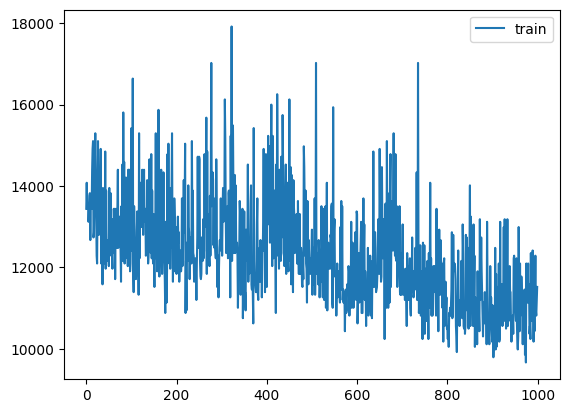

In [26]:
plt.plot(train_history.keys(), train_history.values(), label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [17]:
'''

At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming
At gelu, model is stuck atound 10k
'''

'\n\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming\nAt gelu, model is stuck atound 10k\n'

# Inference

In [18]:
fen_sample ='rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [19]:
def get_score(fen_sample):
    # encoding
    encoder_object = ChessEncoder()
    encoded_fen = torch.tensor(encoder_object.encode_fen(fen_i), dtype=torch.int32).to(device).view(70)
    # print(encoded_fen.shape)
    bs=1
    model = MLPEngine(embedding_dim=32).to(device)
    model.eval()
    y_pred = model(encoded_fen)
    return y_pred.item()
    # run the model

In [20]:
get_score(fen_sample)

-0.3153233528137207

In [21]:
32*70

2240

# TODO
- [x] do inference
<!-- - [ ] evaluate on test dataset -->
- [ ] look for other/ better dataset
- [ ] add regularisation
- [x] add prop initialisation
- [ ] Then start to think about architectural changes
- [ ] do some hyperparameter tuning, maybe grid search or something
  - [ ] learning rate scheduler
  - [ ] embedding dimension changes
  - [ ] model neurons ++
  - [ ] batch/ layer normalisation
  - [ ] different precision
  - [ ] custom loss function of the specific problem
  - [ ] Check for potential gradient vanishing/exploding